# Xenium EAE 5K Processing Walkthrough

This notebook is organized as a step-by-step pipeline from raw Xenium outputs to clustered and spatially visualized cells. Each code cell now has a short markdown guide explaining its purpose, key operations, and expected output so the workflow is easier to review and maintain.


## Step 01: Set Up The Analysis Environment

Import all required libraries and suppress noisy warnings so downstream output is easier to read.

**What this cell does**
- Loads Scanpy, pandas, NumPy, plotting tools, and clustering utilities.
- Keeps notebook output focused on actionable messages during processing.


In [69]:
import warnings
warnings.filterwarnings('ignore')
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

## Step 02: Load Xenium Runs And Attach Metadata

Find each run folder, read expression matrices plus per-cell metadata, and store them as a list of AnnData objects.

**What this cell does**
- Scans `base_dir` for folders that start with `output-`.
- Reads `cell_feature_matrix.h5` and `cells.csv.gz` for each valid run.
- Adds a `run` label so we can trace every cell back to its origin.


In [70]:
base_dir = '/Users/chrislangseth/Downloads/fetal_lung'

runs = [d for d in os.listdir(base_dir) if d.startswith("output-") and os.path.isdir(os.path.join(base_dir, d))]

ad_list = []

for run in runs:
    run_path = os.path.join(base_dir, run)

    # Define file paths directly in each run folder
    h5_path = os.path.join(run_path, 'cell_feature_matrix.h5')
    cell_info_path = os.path.join(run_path, 'cells.csv.gz')

    if not (os.path.exists(h5_path) and os.path.exists(cell_info_path)):
        print(f"Skipping {run_path} (missing required files)")
        continue

    print(f"Loading: {run}")
    ad_int = sc.read_10x_h5(h5_path)
    cell_info = pd.read_csv(cell_info_path, index_col=0)

    ad_int.obs = cell_info
    ad_int.obs['run'] = run

    ad_list.append(ad_int)

Loading: output-XETG00077__0040306__11155-TF-1_ROI_B2__20240621__173354
Loading: output-XETG00077__0040306__11155-TF-1_ROI_B1__20240621__173354


## Step 03: Concatenate Runs Into One AnnData Object

Merge all loaded run-level objects into a single dataset for unified analysis.

**What this cell does**
- Creates one combined `ad` object from `ad_list`.
- Enables end-to-end QC, clustering, and visualization across runs.


In [71]:
ad = sc.concat(ad_list)

## Step 04: Inspect Cell Metadata

Quickly inspect `ad.obs` to confirm metadata columns are present and correctly populated.

**What this cell does**
- Verifies that per-cell annotations loaded correctly.
- Helps catch missing fields before preprocessing.


In [72]:
ad.obs

x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                         
aaabbalf-1  1471.108398   674.559631                 82                     0   
aaaccjdi-1  1452.580566   748.923462                151                     0   
aaacehal-1  1455.703491   742.808533                253                     0   
aaacemlf-1  1436.587769   741.471436                145                     0   
aaaebjjc-1  1466.436890   716.384277                 42                     0   
...                 ...          ...                ...                   ...   
oimpioep-1   977.731018  3549.428223                 76                     0   
oimponce-1   995.189697  3644.947754                 17                     0   
oinamhkm-1   984.310791  3580.583496                 40                     0   
oincihmo-1   955.911438  3382.363037                 13                     0   
oinclckc-1   987.323975  3364.884766                 15                     0   

            control_codeword_counts  unassigned_codeword_counts  \
cell_id                                                           
aaabbalf-1                        0                           0   
aaaccjdi-1                        0                           0   
aaacehal-1                        0                           0   
aaacemlf-1                        0                           0   
aaaebjjc-1                        0                           0   
...                             ...                         ...   
oimpioep-1                        0                           0   
oimponce-1                        0                           0   
oinamhkm-1                        0                           0   
oincihmo-1                        0                           0   
oinclckc-1                        0                           0   

            deprecated_codeword_counts  total_counts   cell_area  \
cell_id                                                            
aaabbalf-1                           0            82   47.052814   
aaaccjdi-1                           0           151   50.033127   
aaacehal-1                           0           253   64.528284   
aaacemlf-1                           0           145   63.444534   
aaaebjjc-1                           0            42   36.441095   
...                                ...           ...         ...   
oimpioep-1                           0            76  104.943129   
oimponce-1                           0            17    7.631407   
oinamhkm-1                           0            40   45.517502   
oincihmo-1                           0            13   10.160157   
oinclckc-1                           0            15    9.708594   

            nucleus_area                                                run  
cell_id                                                                      
aaabbalf-1     29.080626  output-XETG00077__0040306__11155-TF-1_ROI_B2__...  
aaaccjdi-1     25.919688  output-XETG00077__0040306__11155-TF-1_ROI_B2__...  
aaacehal-1     30.209532  output-XETG00077__0040306__11155-TF-1_ROI_B2__...  
aaacemlf-1     28.629064  output-XETG00077__0040306__11155-TF-1_ROI_B2__...  
aaaebjjc-1     11.334219  output-XETG00077__0040306__11155-TF-1_ROI_B2__...  
...                  ...                                                ...  
oimpioep-1      9.663438  output-XETG00077__0040306__11155-TF-1_ROI_B1__...  
oimponce-1      7.631407  output-XETG00077__0040306__11155-TF-1_ROI_B1__...  
oinamhkm-1     11.830938  output-XETG00077__0040306__11155-TF-1_ROI_B1__...  
oincihmo-1      8.037813  output-XETG00077__0040306__11155-TF-1_ROI_B1__...  
oinclckc-1      9.708594  output-XETG00077__0040306__11155-TF-1_ROI_B1__...  

[175512 rows x 11 columns]

## Step 05: Preserve Raw Counts

Store a copy of the original count matrix before normalization and filtering.

**What this cell does**
- Saves raw expression values to `ad.layers["counts"]`.
- Protects an untouched baseline for later comparisons.


In [73]:
ad.layers['counts'] = ad.X.copy()

## Step 06: Write A Raw Data Checkpoint

Save the unprocessed object so this stage can be reused without reloading raw files.

**What this cell does**
- Writes checkpoint file `data/260210_raw.h5ad`.
- Makes the workflow restartable from a known state.


In [74]:
#RENAME 
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_raw.h5ad')

## Step 07: Compute QC Metrics

Calculate quality-control summaries for each cell and gene.

**What this cell does**
- Adds fields such as total counts and detected genes to metadata.
- Provides metrics used in filtering and dashboard plots.


In [75]:
#Information om celler, counts, unika gener etc. 

sc.pp.calculate_qc_metrics(ad, percent_top=None, log1p=False, inplace=True)


## Step 08: Normalize Index Handling In Metadata

Reset the observation index so identifier columns are explicit and easy to group on.

**What this cell does**
- Moves index values into a regular column.
- Simplifies groupby operations used in QC summaries.


In [76]:
#Flyttar ut kolumn
ad.obs = ad.obs.reset_index()

## Step 09: Derive Sample IDs

Create a cleaner sample identifier by parsing the `run` string.

**What this cell does**
- Splits run names on `__` and extracts the sample component.
- Creates `ad.obs["sample_id"]` for plotting and comparisons.


In [77]:
# Skapar sample_id kolumn utifrån run kolumn
ad.obs['sample_id'] = ad.obs.run.str.split('__', expand = True)[2]

In [79]:
ad.obs['sample_id']

0         11155-TF-1_ROI_B2
1         11155-TF-1_ROI_B2
2         11155-TF-1_ROI_B2
3         11155-TF-1_ROI_B2
4         11155-TF-1_ROI_B2
                ...        
175507    11155-TF-1_ROI_B1
175508    11155-TF-1_ROI_B1
175509    11155-TF-1_ROI_B1
175510    11155-TF-1_ROI_B1
175511    11155-TF-1_ROI_B1
Name: sample_id, Length: 175512, dtype: object

## Step 10: Verify Updated Metadata Table

Display `ad.obs` again to confirm the new metadata structure and sample IDs.

**What this cell does**
- Checks that `sample_id` exists and looks correct.
- Confirms data shape before visualization steps.


In [80]:
ad.obs

cell_id   x_centroid   y_centroid  transcript_counts  \
0       aaabbalf-1  1471.108398   674.559631                 82   
1       aaaccjdi-1  1452.580566   748.923462                151   
2       aaacehal-1  1455.703491   742.808533                253   
3       aaacemlf-1  1436.587769   741.471436                145   
4       aaaebjjc-1  1466.436890   716.384277                 42   
...            ...          ...          ...                ...   
175507  oimpioep-1   977.731018  3549.428223                 76   
175508  oimponce-1   995.189697  3644.947754                 17   
175509  oinamhkm-1   984.310791  3580.583496                 40   
175510  oincihmo-1   955.911438  3382.363037                 13   
175511  oinclckc-1   987.323975  3364.884766                 15   

        control_probe_counts  control_codeword_counts  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
...                      ...                      ...   
175507                     0                        0   
175508                     0                        0   
175509                     0                        0   
175510                     0                        0   
175511                     0                        0   

        unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
0                                0                           0          82.0   
1                                0                           0         151.0   
2                                0                           0         253.0   
3                                0                           0         145.0   
4                                0                           0          42.0   
...                            ...                         ...           ...   
175507                           0                           0          76.0   
175508                           0                           0          17.0   
175509                           0                           0          40.0   
175510                           0                           0          13.0   
175511                           0                           0          15.0   

         cell_area  nucleus_area  \
0        47.052814     29.080626   
1        50.033127     25.919688   
2        64.528284     30.209532   
3        63.444534     28.629064   
4        36.441095     11.334219   
...            ...           ...   
175507  104.943129      9.663438   
175508    7.631407      7.631407   
175509   45.517502     11.830938   
175510   10.160157      8.037813   
175511    9.708594      9.708594   

                                                      run  n_genes_by_counts  \
0       output-XETG00077__0040306__11155-TF-1_ROI_B2__...                 60   
1       output-XETG00077__0040306__11155-TF-1_ROI_B2__...                 68   
2       output-XETG00077__0040306__11155-TF-1_ROI_B2__...                 96   
3       output-XETG00077__0040306__11155-TF-1_ROI_B2__...                 66   
4       output-XETG00077__0040306__11155-TF-1_ROI_B2__...                 24   
...                                                   ...                ...   
175507  output-XETG00077__0040306__11155-TF-1_ROI_B1__...                 42   
175508  output-XETG00077__0040306__11155-TF-1_ROI_B1__...                 16   
175509  output-XETG00077__0040306__11155-TF-1_ROI_B1__...                 30   
175510  output-XETG00077__0040306__11155-TF-1_ROI_B1__...                 13   
175511  output-XETG00077__0040306__11155-TF-1_ROI_B1__...                 13   

                sample_id  
0       11155-TF-1_ROI_B2  
1       11155-TF-1_ROI_B2  
2       11155-TF-1_ROI_B2  
3       11155-TF-1_ROI_B2  
4       11155-TF-1_ROI_B2 

## Step 11: Build A Per-Sample QC Summary Table

Aggregate key metrics per sample to get a compact overview of dataset quality and scale.

**What this cell does**
- Computes number of cells, mean counts, and mean genes per sample.
- Sorts samples by cell count to highlight dominant runs.


In [81]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your Xenium dataset ---
# --- Example: basic summary table ---
summary = (
    ad.obs.groupby("sample_id")
    .agg(
        n_cells=("cell_id", "count"),
        mean_counts=("total_counts", "mean"),
        mean_genes=("n_genes_by_counts", "mean"),
    )
    .sort_values("n_cells", ascending=False)
)

## Step 12: Style The QC Summary For Readability

Apply color gradients and number formatting to make summary values easier to scan.

**What this cell does**
- Uses pandas Styler to highlight relative magnitudes.
- Formats table values for clear reporting in the notebook.


In [82]:
# Pretty print with formatting
styled = (
    summary.style
    .background_gradient(subset=["n_cells"], cmap="Purples")
    .background_gradient(subset=["mean_counts"], cmap="Blues")
    .background_gradient(subset=["mean_genes"], cmap="Greens")
    .format({
        "n_cells": "{:,.0f}",
        "counts_mean": "{:.1f}",
        "counts_median": "{:.0f}",
        "counts_p10": "{:.0f}",
        "counts_p90": "{:.0f}",
        "genes_mean": "{:.1f}",
        "genes_median": "{:.0f}",
        "genes_p10": "{:.0f}",
        "genes_p90": "{:.0f}",
    })
    .set_caption("📊 Xenium QC Summary per Sample")
)
styled

## Step 13: Run A Full QC Dashboard And Export Figures

Generate a reusable QC report: summary CSV, per-run plots, composition charts, and gene detection coverage.

**What this cell does**
- Creates outputs under `xenium_qc/` (tables and PNG figures).
- Includes cell count, counts/genes distributions, composition, and detection-rate diagnostics.
- Handles optional columns gracefully so the cell can run on similar datasets.


## Step 15: Filter Low-Quality Cells

Remove cells with very low transcript counts or too few detected genes.

**What this cell does**
- Applies minimum thresholds for `min_counts` and `min_genes`.
- Reduces noise and stabilizes downstream embeddings and clustering.


In [83]:
sc.pp.filter_cells(ad,min_counts=15)
sc.pp.filter_cells(ad,min_genes=5)

## Step 16: Normalize And Log-Transform Expression

Scale counts per cell to a shared depth, then apply log transformation.

**What this cell does**
- Runs total-count normalization with a target sum of 100.
- Applies `log1p` so expression distributions are more comparable.


In [84]:
sc.pp.normalize_total(ad, inplace=True,target_sum=100)
sc.pp.log1p(ad)
#sc.pp.scale(ad, )#max_value=10)

## Step 17: Compute PCA And Neighbor Graph

Reduce dimensionality and build the neighbor graph that drives manifold learning and clustering.

**What this cell does**
- Calculates PCA and visualizes explained variance.
- Builds KNN graph using selected PCs and neighbor count.


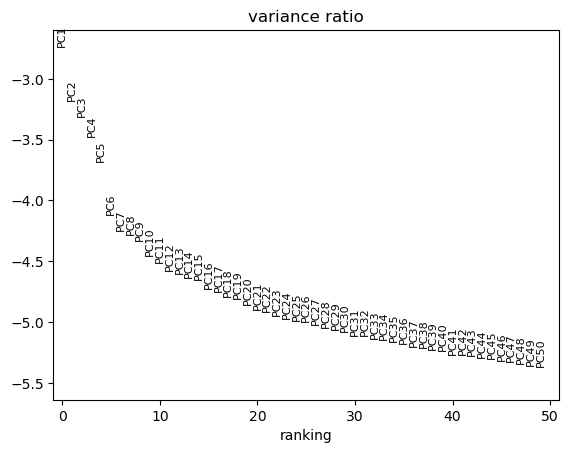

In [85]:
sc.tl.pca(ad)
sc.pl.pca_variance_ratio(ad, n_pcs=50, log=True)
sc.pp.neighbors(ad, n_neighbors=15, n_pcs=30)

## Step 18: Generate UMAP Embedding

Project cells into a 2D manifold for visual exploration of structure and clusters.

**What this cell does**
- Computes UMAP coordinates from the neighbor graph.
- Uses `min_dist=0.1` to control cluster compactness.


In [86]:
sc.tl.umap(ad, min_dist=0.1)

## Step 19: Plot UMAP By Sample

Color the UMAP by sample identity to inspect batch effects and sample mixing.

**What this cell does**
- Draws cells with small point size for dense visualization.
- Helps assess whether runs overlap in expression space.


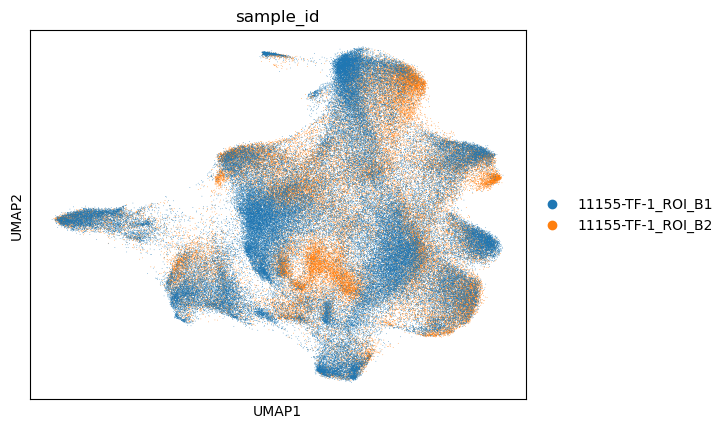

In [87]:
sc.pl.umap(ad, color=['sample_id'], s=1)

## Step 20: Run Multi-Resolution Leiden Clustering

Cluster the same embedding at several resolutions to compare coarse vs fine partitions.

**What this cell does**
- Creates labels like `leiden_0.1`, `leiden_0.5`, ..., `leiden_2`.
- Skips recomputation if a label already exists.
- Plots each clustering result on UMAP.


Clustering at resolution 0.1...
Done.


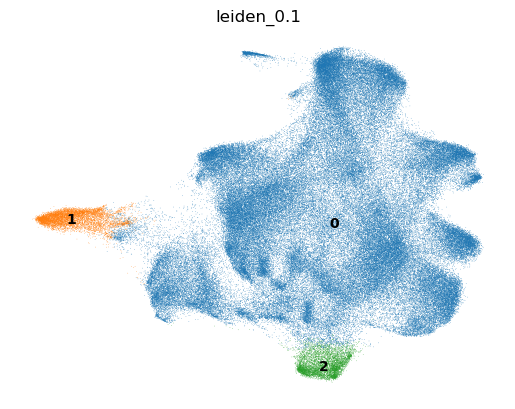

Clustering at resolution 0.5...
Done.


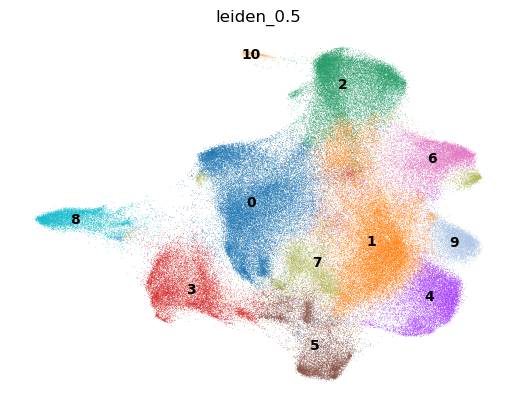

Clustering at resolution 1...
Done.


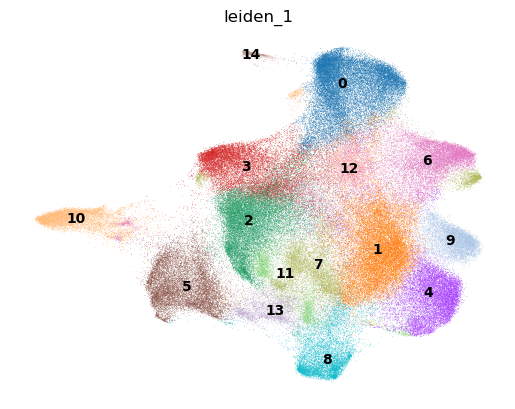

Clustering at resolution 1.5...
Done.


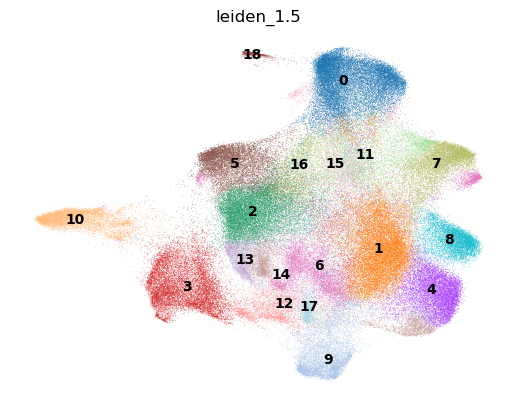

Clustering at resolution 2...
Done.


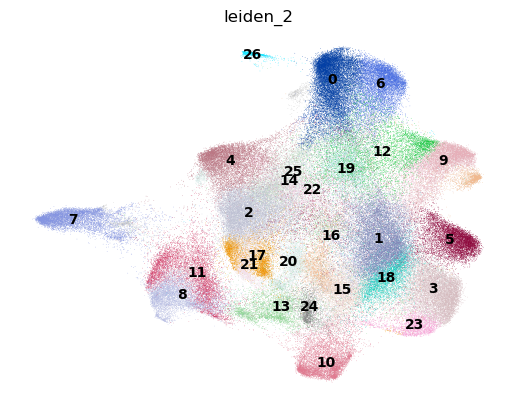

In [88]:
resolutions = [0.1,0.5, 1,1.5, 2]

for resolution in resolutions:
    key = f'leiden_{resolution}'

    if key in ad.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(ad, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(ad, color=key, legend_loc='on data', frameon=False)

## Step 21: Save Clustered Checkpoint

Persist the post-clustering AnnData object for later spatial and marker analysis.

**What this cell does**
- Writes `data/260210_clustered.h5ad`.
- Creates a stable checkpoint after expensive preprocessing.


In [90]:
#RENAME (checkpoint)
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

## Step 22: Reload Clustered Dataset

Load the saved checkpoint to continue work from a clean, reproducible state.

**What this cell does**
- Reads `data/260210_clustered.h5ad` into `ad`.
- Useful when resuming the notebook in a new session.


In [92]:
#RENAME
ad = sc.read('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

## Step 23: Attach Spatial Coordinates

Build the standard `obsm["spatial"]` matrix from centroid columns.

**What this cell does**
- Uses `x_centroid` and `y_centroid` from metadata.
- Prepares data for custom spatial plotting functions.


In [93]:
spatial = np.array(ad.obs[['x_centroid','y_centroid']])
ad.obsm['spatial'] = spatial

## Step 24: Confirm Spatial Embedding Is Present

Display the AnnData object to verify that spatial coordinates are registered.

**What this cell does**
- Quick sanity check before importing plotting utilities.
- Ensures required structure exists for spatial visualization.


In [94]:
#kör och kolla att det står spatial
ad

AnnData object with n_obs × n_vars = 165625 × 480
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'run', 'n_genes_by_counts', 'sample_id', 'n_counts', 'n_genes', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden_0.1', 'leiden_0.1_colors', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Step 25: Import Project-Specific Spatial Utilities

Add a local project path and import helper plotting functions not included in Scanpy.

**What this cell does**
- Extends `sys.path` to the BaloMS utilities directory.
- Imports `spatial_utils` for compact spatial plotting.


In [95]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

## Step 26: Plot Spatial Clusters Across Samples

Render cluster labels in physical tissue space using the custom compact plotting routine.

**What this cell does**
- Colors spots by `leiden_1.5` clusters.
- Facets plots by `sample_id` for side-by-side comparison.


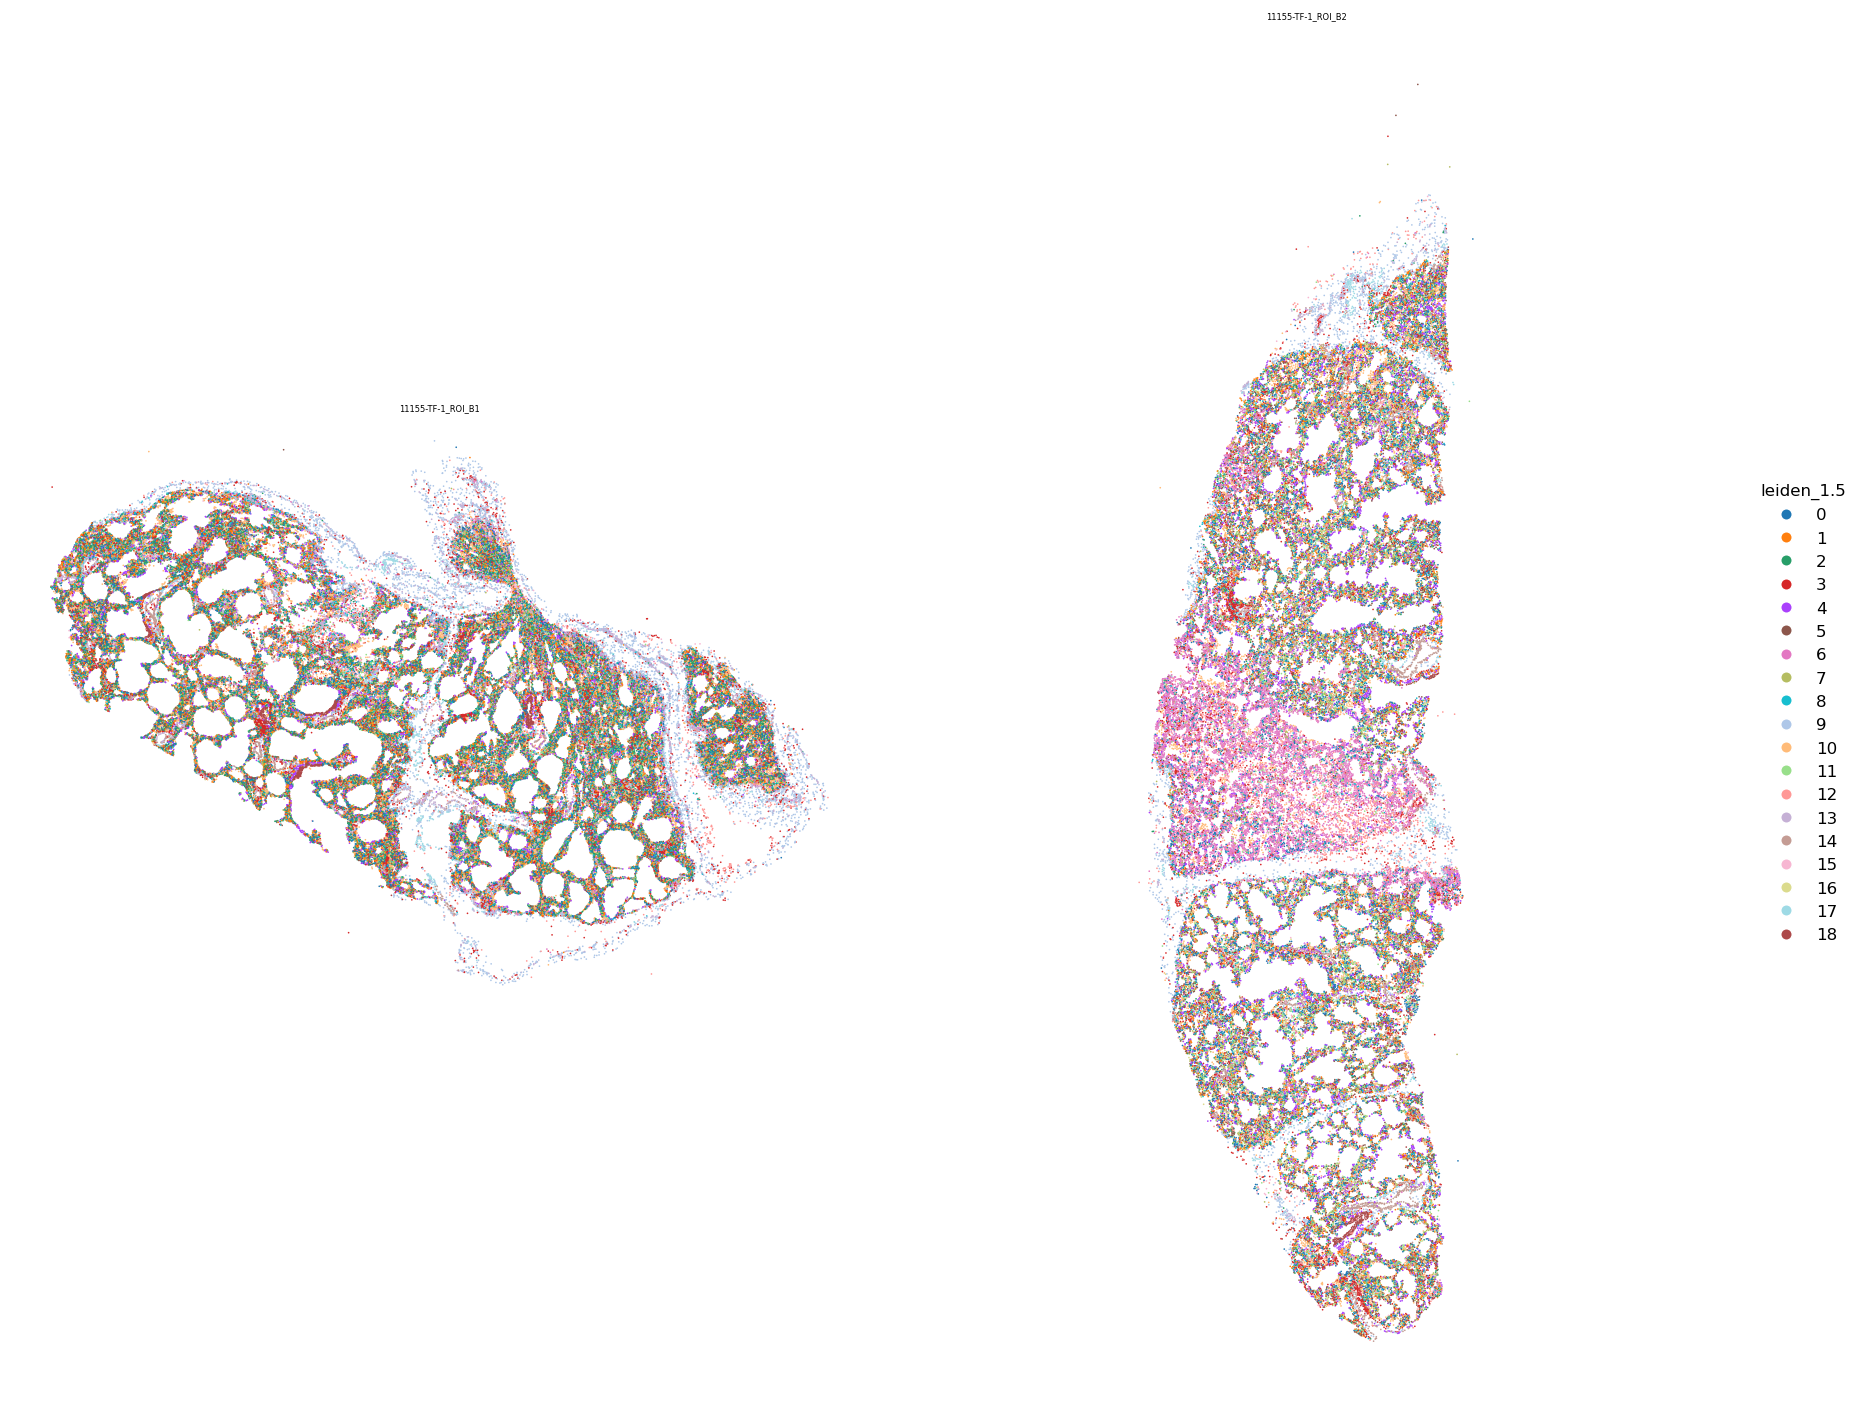

In [96]:
# usage
spatial_utils.plot_spatial_compact_fast(
    ad,
    color="leiden_1.5",
    groupby="sample_id",
    spot_size=1,
    cols=2,
    height=12,
    legend_col_width=1.0,
)

## Step 27: Plot Per-Run Spatial Maps

Loop over runs and generate one spatial cluster map per run for detailed inspection.

**What this cell does**
- Subsets AnnData by each unique `run` value.
- Plots `leiden_2` assignments in each run independently.


output-XETG00077__0040306__11155-TF-1_ROI_B2__20240621__173354


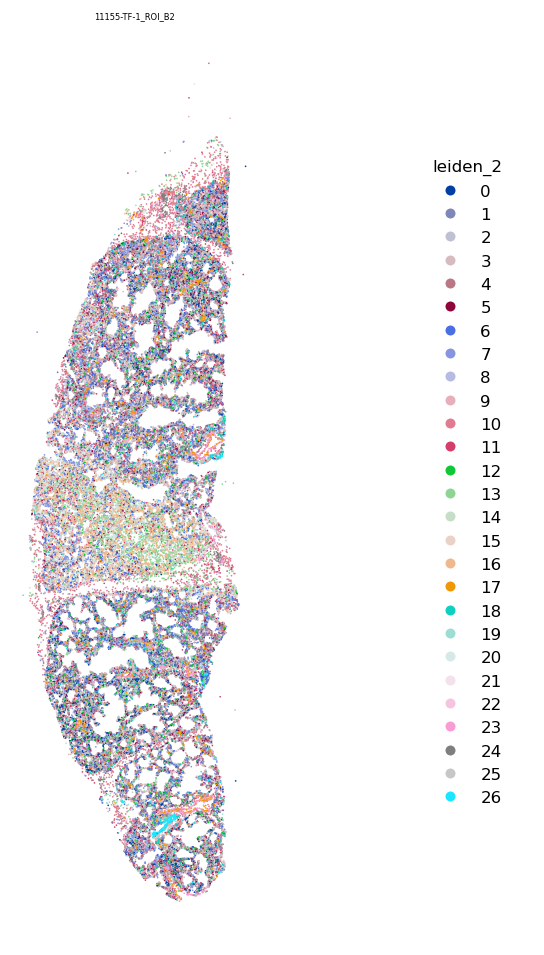

output-XETG00077__0040306__11155-TF-1_ROI_B1__20240621__173354


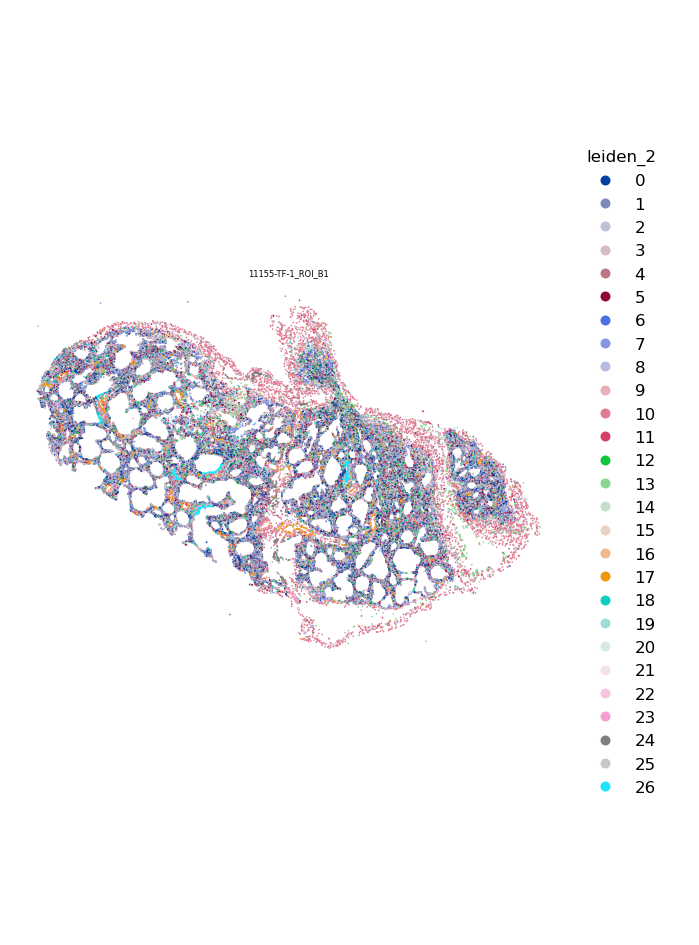

In [97]:
for run in ad.obs['run'].unique():
    print(run)
    ad_int = ad[ad.obs['run'] == run]
    # usage
    spatial_utils.plot_spatial_compact_fast(
        ad_int,
        color="leiden_2",
        groupby="sample_id",
        spot_size=1,
        cols=1,
        height=8,
        legend_col_width=1.0,
    )
    

## Step 28: Identify Marker Genes Per Cluster

Run differential expression between clusters and preview top-ranked genes.

**What this cell does**
- Uses `sc.tl.rank_genes_groups` with t-test.
- Plots ranked genes and stores a tidy marker table in memory.


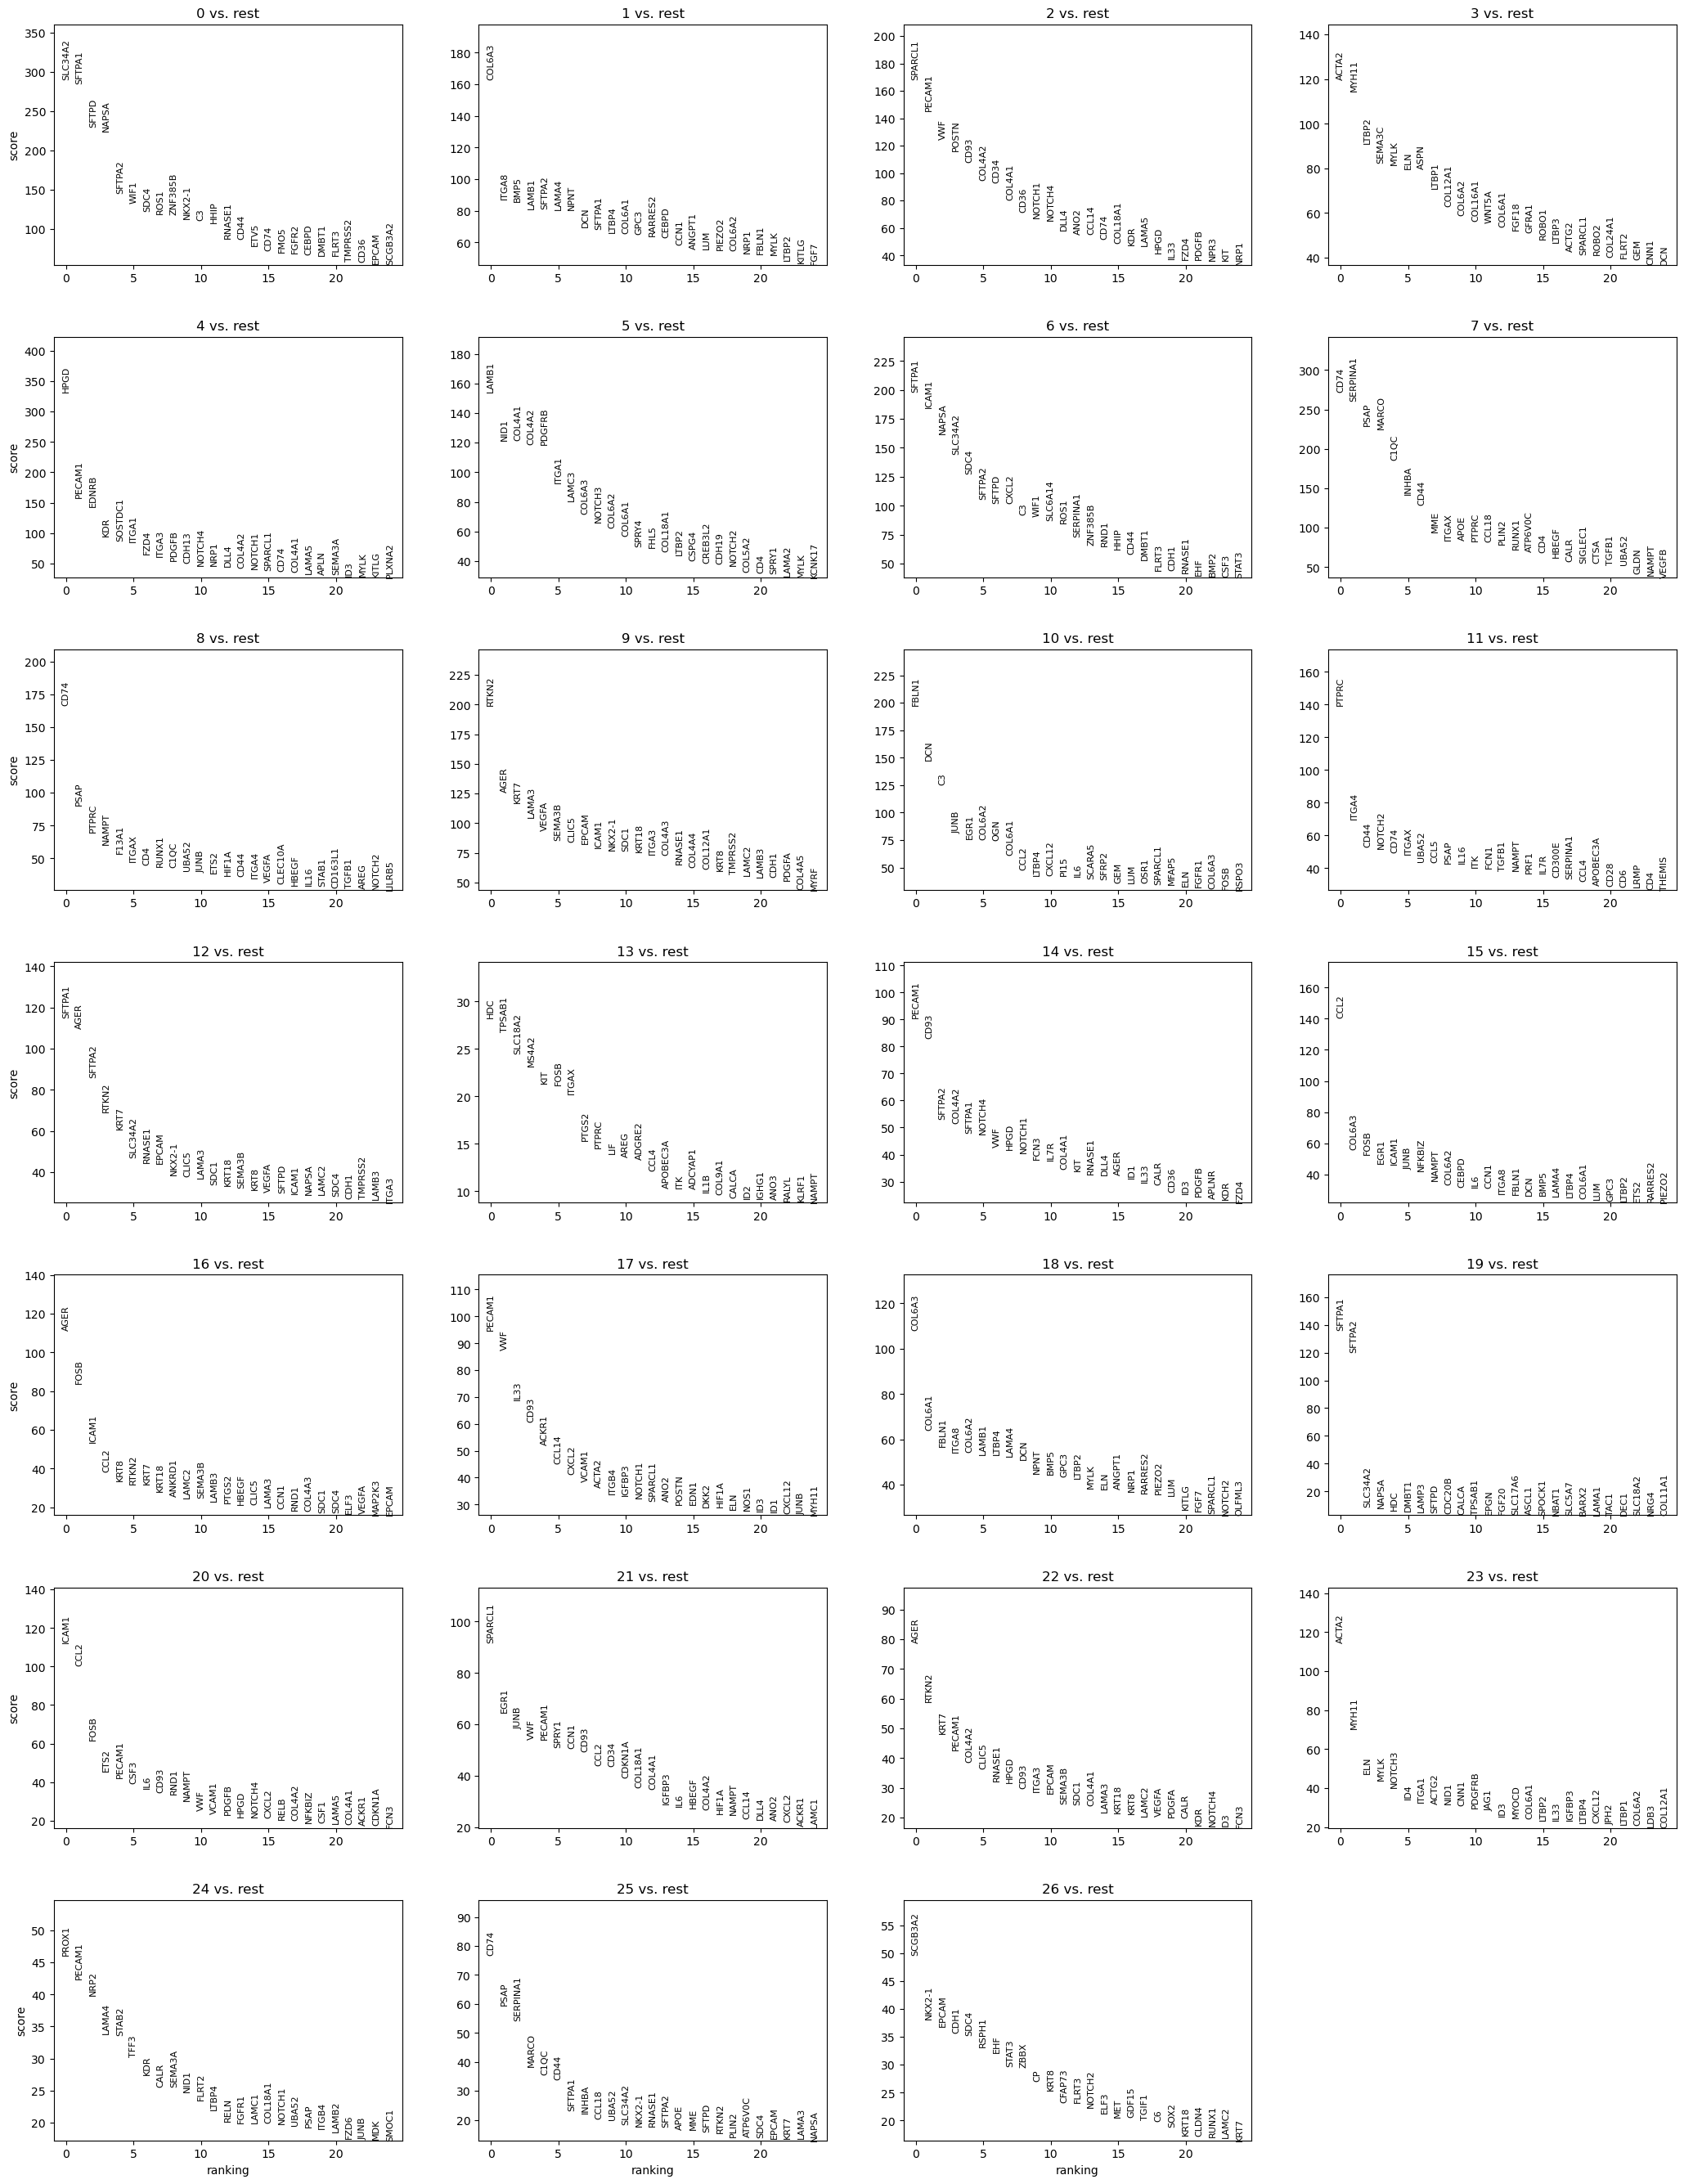

group    names      scores  logfoldchanges  pvals  pvals_adj
0     0  SLC34A2  290.222137        3.052041    0.0        0.0
1     0   SFTPA1  285.335876        2.417320    0.0        0.0
2     0    SFTPD  230.160507        3.220369    0.0        0.0
3     0    NAPSA  224.898132        3.223064    0.0        0.0
4     0   SFTPA2  145.243042        1.332118    0.0        0.0

In [98]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(ad, groupby="leiden_2", method="t-test")
sc.pl.rank_genes_groups(ad, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(ad, group=None)
markers.head()

## Step 29: Extract Top Marker Lists For Annotation

Collect top genes for each cluster and print them in a compact format for manual cell-type annotation.

**What this cell does**
- Builds a table of top 30 genes per Leiden cluster.
- Prints each list for quick use in downstream annotation notes.


In [99]:
marker_genes = pd.DataFrame({
    group: ad.uns['rank_genes_groups']['names'][group][:30]
    for group in ad.uns['rank_genes_groups']['names'].dtype.names
})

for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
SLC34A2 SFTPA1 SFTPD NAPSA SFTPA2 WIF1 SDC4 ROS1 ZNF385B NKX2-1 C3 HHIP RNASE1 CD44 ETV5 CD74 FMO5 FGFR2 CEBPD DMBT1 FLRT3 TMPRSS2 CD36 EPCAM SCGB3A2 CDH1 EHF ITGB6 LAMP3 FZD5
 
1
COL6A3 ITGA8 BMP5 LAMB1 SFTPA2 LAMA4 NPNT DCN SFTPA1 LTBP4 COL6A1 GPC3 RARRES2 CEBPD CCN1 ANGPT1 LUM PIEZO2 COL6A2 NRP1 FBLN1 MYLK LTBP2 KITLG FGF7 FGFR4 ROBO2 NOTCH2 VEGFD GDF10
 
2
SPARCL1 PECAM1 VWF POSTN CD93 COL4A2 CD34 COL4A1 CD36 NOTCH1 NOTCH4 DLL4 ANO2 CCL14 CD74 COL18A1 KDR LAMA5 HPGD IL33 FZD4 PDGFB NPR3 KIT NRP1 FZD6 UBA52 SPRY4 BMP6 ETS2
 
3
ACTA2 MYH11 LTBP2 SEMA3C MYLK ELN ASPN LTBP1 COL12A1 COL6A2 COL16A1 WNT5A COL6A1 FGF18 GFRA1 ROBO1 LTBP3 ACTG2 SPARCL1 ROBO2 COL24A1 FLRT2 GEM CNN1 DCN COL4A5 MYOCD LGR6 CCN2 COL5A2
 
4
HPGD PECAM1 EDNRB KDR SOSTDC1 ITGA1 FZD4 ITGA3 PDGFB CDH13 NOTCH4 NRP1 DLL4 COL4A2 NOTCH1 SPARCL1 CD74 COL4A1 LAMA5 APLN SEMA3A ID3 MYLK KITLG PLXNA2 JAG1 LAMB2 CD34 AGER TGFB1
 
5
LAMB1 NID1 COL4A1 COL4A2 PDGFRB ITGA1 LAMC3 COL6A3 NOTCH3 COL6A2 COL6A1 SPRY4 FHL5 COL18A1 LTBP

## Step 30: Write Final Analysis Object

Save the updated AnnData object after marker analysis and spatial setup.

**What this cell does**
- Overwrites `data/260210_clustered.h5ad` with latest state.
- Keeps one file containing cluster labels and analysis-ready metadata.


In [101]:
#RENAME
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

In [103]:
ad = sc.read_h5ad('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

In [105]:
# Find HVGs
sc.pp.highly_variable_genes(
    ad,
    n_top_genes=100,
    flavor="seurat_v3"
)


In [106]:
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

Seed set to 12345
Seed set to 12345


In [110]:
scvi.model.SCVI.setup_anndata(
    ad, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad)

In [111]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs = 30)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 30/30: 100%|██████████| 30/30 [08:22<00:00, 15.79s/it, v_num=1, train_loss=132]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [08:22<00:00, 16.76s/it, v_num=1, train_loss=132]


In [112]:
ad.obsm['X_scVI'] = model.get_latent_representation(ad).astype(np.float32)


In [113]:
sq.gr.spatial_neighbors(ad, library_key='sample_id', coord_type='generic', delaunay=True, percentile=99)


In [114]:
cc.gr.remove_long_links(ad)


In [115]:
cc.gr.aggregate_neighbors(ad, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample_id')


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


In [116]:
# GMM components to try
# GMM components to try
gmm_components = [10, 15,20]



In [117]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = ad.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    ad.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = ad.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


10
k=10: 10 clusters
15
k=15: 15 clusters
20
k=20: 20 clusters


In [118]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

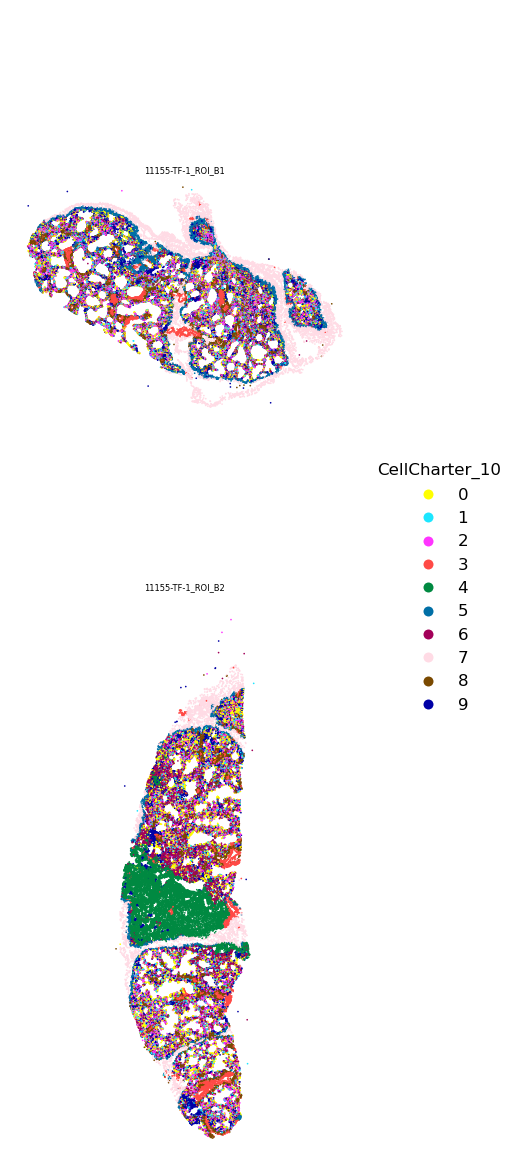

In [121]:
spatial_utils.plot_spatial_compact_fast(
    ad,
    color="CellCharter_10",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)


In [122]:
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered_niche.h5ad')